In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import datetime
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from pathlib import Path
import pickle
from IPython.display import display, Markdown, Latex

/Users/yanran/miniconda3/envs/hw2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/yanran/miniconda3/envs/hw2/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/yanran/miniconda3/envs/hw2/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/yanran/miniconda3/envs/hw2/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/yanran/miniconda3/envs/hw2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

# Initialize Model

In [14]:
bit_lengths = [7,6,5,4,3]


In [3]:
model_path = Path('./models')

In [4]:
fig_path = Path('./figures')

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_data = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

100%|██████████| 170498071/170498071 [03:11<00:00, 889648.84it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
import torchvision.models as models
path = "Automated_Output"
def create_model(bit_length):
    vgg16 = models.vgg16(pretrained=False)
    vgg16.classifier[4] = nn.Linear(4096,1024)
    vgg16.classifier[6] = nn.Linear(1024,10)
    vgg16.load_state_dict(torch.load(f'{path}/dt_quantized_model_bl_{bit_length}',map_location=device))
    # vgg16.load_state_dict(torch.load(f'model_20240610_113550_DT_Quantized_NEW',map_location=device))

    vgg16.eval()
    return vgg16

In [10]:
accuracies = {7: 85.22, 6: 85.12, 5: 85.06, 4: 84.87, 3: 83.51, 2: 83.51}#, 1: 25.24}

In [11]:
# plt.plot(list(accuracies.keys()), list(accuracies.values()))
# plt.gca().invert_xaxis()
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Number of bits')
# plt.title('vgg16 Accuracy vs Number of DT Bits')
# plt.savefig(fig_path / 'vgg16_accuracy_v_bits.png')

---

In [15]:
counts = []
for bit_length in bit_lengths:
    with open(f'Automated_Output/dt_counts_bl_{bit_length}.pkl', 'rb') as f:
        counts.append(pickle.load(f))
        print(f'{bit_length} bit exponent counts: {counts[-1]}')

FileNotFoundError: [Errno 2] No such file or directory: 'Automated_Output/dt_counts_bl_7.pkl'

In [ ]:
my_models = {}
for bit_length in bit_lengths:
    my_models[bit_length] = create_model(bit_length);

In [ ]:
def num_unique_vals(model):
    return np.unique(model.classifier[4].weight.flatten().detach().numpy()).shape
for bit_length in bit_lengths:
    print(f'Number of unique values for {bit_length} exponent dt quantization: {num_unique_vals(models[bit_length])}')

TypeError: 'module' object is not subscriptable

# Size Estimation

In [15]:
def estimate_model_size_change(alexnet, bit_length):
    data_type_sizes = []
    abs_max_sizes = []
    count = 0
    bits_in_fp32 = 8 + 23
    for layer in [*alexnet.features,*alexnet.classifier]:
        count += 1 
        # curr_layer_path = curr_path / f'layer{count}.npy' 
        curr_data_size = 0
        curr_abs_max_size = 0
        try:
            data_type_sizes.append(0)
            abs_max_sizes.append(0)
            if len(layer.weight.shape) == 4:
                weights = layer.weight.detach()
                # print(f'Layer {count}')# weights shape pre-quantization: {weights.shape}\nWeights: {weights}')
                for filter in range(0, weights.shape[0]):
                    # print(f'Filter num {filter}')
                    for channel in range(0, weights.shape[1]):
                        # print(f'Channel num {channel}')
                        # print(layer.weight[filter,channel])
                        data_type_sizes[-1] += weights[filter,channel].numel()
                        abs_max_sizes[-1] += weights[filter,channel].shape[0]
                        # for row in range(0,weights.shape[2]):
                        #     weights[filter,channel, row] = quantize_dequantize_dt(weights[filter,channel,row])
                        # print(f'Finish window')
                # print(f'Layer {count} weights shape post-quantization: {weights.shape}\nWeights: {weights}')
                # layer.weight = nn.parameter.Parameter(weights)
                # print(f'Layer {count} weights shape post-quantization: {weights.shape}\nWeights: {weights}')
                # layer.weight = nn.parameter.Parameter(weights)
            else:
                weights = layer.weight.detach()
                # print(f'Layer {count}')# weights shape pre-quantization: {layer.weight.shape}\nWeights: {weights}')
                data_type_sizes[-1] += weights.numel()
                abs_max_sizes[-1] += weights.shape[0]
                # print(weights.shape)
                # for row in tqdm(range(0,weights.shape[0])):
                #     weights[row] = quantize_dequantize_dt(weights[row])
                # layer.weight = nn.parameter.Parameter(weights)
                # print(f'Layer {count} weights shape post-quantization: {layer.weight.shape}\nWeights: {weights}')
                # print(layer.weight)
        except (TypeError, AttributeError):
            pass
    return {'data_type_counts': np.array(data_type_sizes), 'data_type_sizes': np.array(data_type_sizes) * bit_length, 'abs_max_counts': np.array(abs_max_sizes), 'abs_max_sizes': np.array(abs_max_sizes) * bits_in_fp32,
           'data_type_sizes_original': np.array(data_type_sizes) * bits_in_fp32}

In [16]:
def bits_to_mb(bits):
    return bits / 8000000

In [17]:
def compute_model_size(model, bit_len):
    bits_in_fp32 = 8 + 23
    results = estimate_model_size_change(model, bit_len)
    data_type_size = results['data_type_sizes'].sum()
    abs_max_size = results['abs_max_sizes'].sum()
    dt_counts = results['data_type_counts'].sum()
    display(Markdown(f'## {bit_len} bits'))
    print(f'{data_type_size} bits to represent the {bit_len} quantized dt and {abs_max_size} bits to represent the maxes')
    print(f'{bits_to_mb(data_type_size)} mb to represent the {bit_len} quantized dt and {bits_to_mb(abs_max_size)} mb to represent the maxes')
    print(f'\nOriginal Model Size: {bits_to_mb( dt_counts * bits_in_fp32)} MB')
    print(f'Quantized Model Size: {bits_to_mb( data_type_size +abs_max_size)} MB')
    print(f'This is a {bits_to_mb( dt_counts * bits_in_fp32) / (bits_to_mb(data_type_size)+bits_to_mb(abs_max_size))}x decrease in size')
    return (bits_to_mb(data_type_size)+bits_to_mb(abs_max_size))

In [18]:
compressed_sizes = []
for bit_length in bit_lengths:
    compressed_sizes.append(compute_model_size(create_model(bit_length), bit_length))
    display(Markdown('---'))

## 7 bits

969168704 bits to represent the 7 quantized dt and 152294134 bits to represent the maxes
121.146088 mb to represent the 7 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 140.18285475 MB
This is a 3.8271734796440926x decrease in size


---

## 6 bits

830716032 bits to represent the 6 quantized dt and 152294134 bits to represent the maxes
103.839504 mb to represent the 6 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 122.87627075 MB
This is a 4.366214084504188x decrease in size


---

## 5 bits

692263360 bits to represent the 5 quantized dt and 152294134 bits to represent the maxes
86.53292 mb to represent the 5 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 105.56968675 MB
This is a 5.081990110196097x decrease in size


---

## 4 bits

553810688 bits to represent the 4 quantized dt and 152294134 bits to represent the maxes
69.226336 mb to represent the 4 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 88.26310275 MB
This is a 6.078464129225278x decrease in size


---

## 3 bits

415358016 bits to represent the 3 quantized dt and 152294134 bits to represent the maxes
51.919752 mb to represent the 3 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 70.95651875 MB
This is a 7.561026294007695x decrease in size


---

## 2 bits

276905344 bits to represent the 2 quantized dt and 152294134 bits to represent the maxes
34.613168 mb to represent the 2 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 53.64993475 MB
This is a 10.000088658076141x decrease in size


---

## 1 bits

138452672 bits to represent the 1 quantized dt and 152294134 bits to represent the maxes
17.306584 mb to represent the 1 quantized dt and 19.03676675 mb to represent the maxes

Original Model Size: 536.504104 MB
Quantized Model Size: 36.34335075 MB
This is a 14.762097960931685x decrease in size


---

Text(0.5, 1.0, 'VGG16 Weights Size vs Number of Bits')

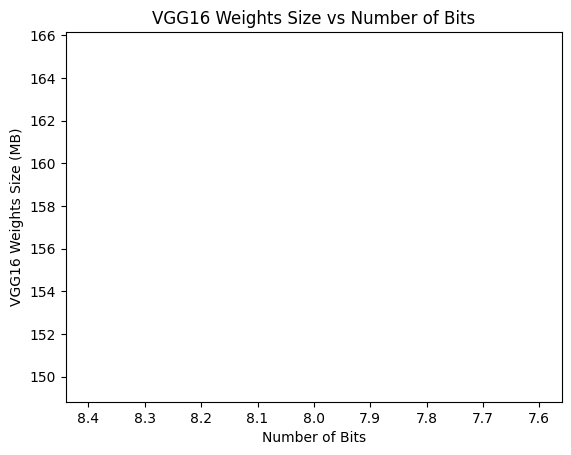

In [ ]:
plt.plot(bit_lengths,compressed_sizes)
plt.gca().invert_xaxis()
plt.xlabel('Number of Bits')
plt.ylabel('VGG16 Weights Size (MB)')
plt.title('VGG16 Weights Size vs Number of Bits')

# MSE Computer

In [ ]:
# Flatten and Concatenate Entire Network

In [36]:
def flatten_model(model):
    flattened_model = torch.tensor([])
    for layer in [*model.features,*model.classifier]:
        try:
            weights = layer.weight.detach()
            flattened_model = torch.concatenate((flattened_model, weights.flatten()))
        except (TypeError, AttributeError):
            pass
    return flattened_model

In [ ]:
flatten_model(alexnet).shape

torch.Size([44421824])

In [38]:
import torchvision.models as models
device = 'cpu'
vgg16 = models.vgg16(pretrained=False)
model_path = 'checkpoints/finetuned_vgg16_9'
vgg16.classifier[4] = nn.Linear(4096,1024)
vgg16.classifier[6] = nn.Linear(1024,10)
vgg16.load_state_dict(torch.load(model_path))
vgg16.to(device)
output = ''
for bit_length in bit_lengths:
    model = create_model(bit_length)
    flattened_vgg16 = flatten_model(vgg16)
    flattened_quantized_vgg16 = flatten_model(model)
    model_size = flattened_vgg16.shape[0]
    MSE = torch.sum(torch.pow(flattened_vgg16 - flattened_quantized_vgg16, 2)) / model_size
    # MAE = torch.sum(torch.abs(flattened_vgg16 - flattened_quantized_vgg16)) / model_size
    print(f'{bit_length} model MSE: {MSE}')
    output += f'{bit_length} model MSE: {MSE}\n'
print(output)

8 model MSE: 1.5750142523529576e-08
7 model MSE: 1.9603097811682346e-08
6 model MSE: 3.5132252662606334e-08
5 model MSE: 1.0101683756147395e-07
4 model MSE: 3.602037565997307e-07
3 model MSE: 1.3539826113628806e-06
2 model MSE: 1.3539826113628806e-06
1 model MSE: 0.00012342177797108889
8 model MSE: 1.5750142523529576e-08
7 model MSE: 1.9603097811682346e-08
6 model MSE: 3.5132252662606334e-08
5 model MSE: 1.0101683756147395e-07
4 model MSE: 3.602037565997307e-07
3 model MSE: 1.3539826113628806e-06
2 model MSE: 1.3539826113628806e-06
1 model MSE: 0.00012342177797108889



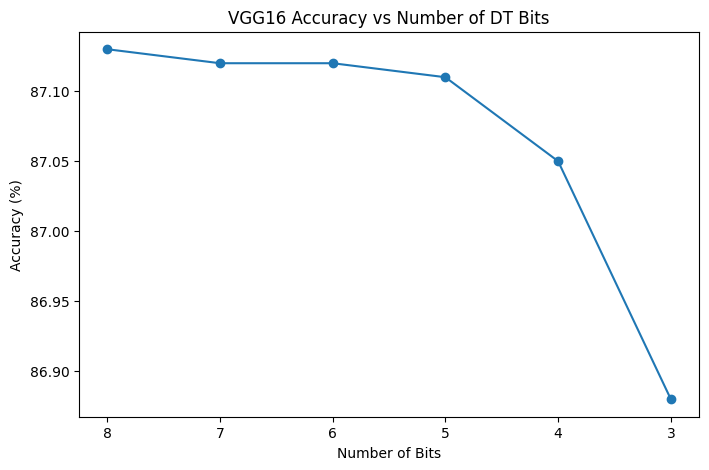

In [ ]:

import matplotlib.pyplot as plt

# Data (number of bits in decreasing order)
bits = [8, 7, 6, 5, 4, 3]
accuracy = [87.13, 87.12, 87.12, 87.11, 87.05, 86.88]


# Configure the plot
plt.figure(figsize=(8, 5))
plt.plot(bits, accuracy, marker='o', linestyle='-')
plt.gca().invert_xaxis()

plt.title("VGG16 Accuracy vs Number of DT Bits")
plt.xlabel("Number of Bits")
plt.ylabel("Accuracy (%)")
# plt.grid(True)

# Display the plot
plt.show()

In [ ]:
data = {
    6: {0: 87556523, 1: 45487232, 2: 4868056, 3: 486757, 4: 48823, 5: 5281, 6: 0, 7: 0},
    5: {0: 87556523, 1: 45487232, 2: 4868056, 3: 486757, 4: 54104, 5: 0, 6: 0, 7: 0},
    4: {0: 87556523, 1: 45487232, 2: 4868056, 3: 540861, 4: 0, 5: 0, 6: 0, 7: 0},
    3: {0: 87556523, 1: 45487232, 2: 5408917, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
    2: {0: 87556523, 1: 50896149, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
    1: {0: 138452672, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0},
}

# Get the total count for each bit exponent
total_counts = {k: sum(v.values()) for k, v in data.items()}

# Create the table header with 0.00% at the beginning
print("0.00%        Bit Exponent Counts")

# Iterate through each bit exponent data
for bit_exponent, counts in data.items():
  # Calculate percentage for each count
  percentages = {k: (v / total_counts[bit_exponent]) * 100 for k, v in counts.items()}

  # Print bit exponent counts and percentages
  print(f"{', '.join([f'{count:.2f} ({percentages[count]:.2f}%)' for count in counts])}  {bit_exponent:6}")

0.00%        Bit Exponent Counts
0.00 (63.24%), 1.00 (32.85%), 2.00 (3.52%), 3.00 (0.35%), 4.00 (0.04%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       6
0.00 (63.24%), 1.00 (32.85%), 2.00 (3.52%), 3.00 (0.35%), 4.00 (0.04%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       5
0.00 (63.24%), 1.00 (32.85%), 2.00 (3.52%), 3.00 (0.39%), 4.00 (0.00%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       4
0.00 (63.24%), 1.00 (32.85%), 2.00 (3.91%), 3.00 (0.00%), 4.00 (0.00%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       3
0.00 (63.24%), 1.00 (36.76%), 2.00 (0.00%), 3.00 (0.00%), 4.00 (0.00%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       2
0.00 (100.00%), 1.00 (0.00%), 2.00 (0.00%), 3.00 (0.00%), 4.00 (0.00%), 5.00 (0.00%), 6.00 (0.00%), 7.00 (0.00%)       1


In [34]:
import numpy as np

data = np.array([
    [87556523, 45487232, 4868056, 486757, 48823, 4728, 506, 47],
    [87556523, 45487232, 4868056, 486757, 48823, 4728, 553, 0],
    [87556523, 45487232, 4868056, 486757, 48823, 5281, 0, 0],
    [87556523, 45487232, 4868056, 486757, 54104, 0, 0, 0],
    [87556523, 45487232, 4868056, 540861, 0, 0, 0, 0],
    [87556523, 45487232, 5408917, 0, 0, 0, 0, 0],
    [87556523, 50896149, 0, 0, 0, 0, 0, 0],
    [138452672, 0, 0, 0, 0, 0, 0, 0]
])

# Calculate percentages for each row
percentages = data / data.sum(axis=1, keepdims=True) * 100

# Print the table with percentages (formatted to 2 decimal places)
print("{:10s} {:10.6f}% {:10.6f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.8f}%".format("Bit Len", *percentages[0]))
for row in percentages[1:]:
  print("{:10s} {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.2f}% {:10.8f}%".format(" ", *row))


Bit Len     63.239316%  32.853994%       3.52%       0.35%       0.04%       0.00%       0.00% 0.00003395%
                63.24%      32.85%       3.52%       0.35%       0.04%       0.00%       0.00% 0.00000000%
                63.24%      32.85%       3.52%       0.35%       0.04%       0.00%       0.00% 0.00000000%
                63.24%      32.85%       3.52%       0.35%       0.04%       0.00%       0.00% 0.00000000%
                63.24%      32.85%       3.52%       0.39%       0.00%       0.00%       0.00% 0.00000000%
                63.24%      32.85%       3.91%       0.00%       0.00%       0.00%       0.00% 0.00000000%
                63.24%      36.76%       0.00%       0.00%       0.00%       0.00%       0.00% 0.00000000%
               100.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00% 0.00000000%
